# Tabular - Binary Classification using DNNs

By [Akshaj Verma](https://akshajverma.com/)

This notebook takes you through the implementation of binary classification using feedforward networks on the [lower back pain symptoms dataset](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) using PyTorch.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
torch.manual_seed(69)
np.random.seed(21)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

print("We're using cuda?", torch.cuda.is_available())

We're using cuda? True


In [4]:
df = pd.read_csv("../../../data/tabular/classification/spine_dataset.csv")

## Pre-processing

In [5]:
df = df.iloc[:, 0:-1]

In [6]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


In [7]:
print("Number of rows:", len(df))

Number of rows: 310


In [8]:
df.describe()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200


We observe that there's a class imbalance here. So, we need to perform stratified splitting here. 

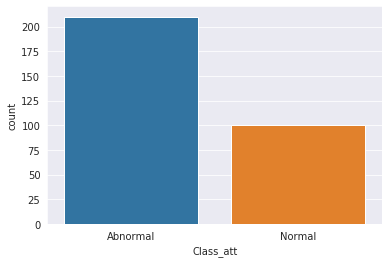

In [9]:
sns.countplot(x = 'Class_att', data=df)

In [10]:
df['Class_att'] = df['Class_att'].astype('category')

In [11]:
class2idx = {
    'Abnormal': 1,
    'Normal': 0
}

idx2class = {v: k for k, v in class2idx.items()}

df['Class_att'].replace(class2idx, inplace=True)

In [12]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train - Validation - Test

In [13]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [15]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [16]:
def get_class_distribution(obj):
    count_dict = {
        "normal": 0,
        "abnormal": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['normal'] += 1
        elif i == 1: 
            count_dict['abnormal'] += 1
        else:
            print("Check classes.")
            
    return count_dict 

In [17]:
print("Train:", get_class_distribution(y_train))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {'normal': 72, 'abnormal': 151}
Test : {'normal': 20, 'abnormal': 42}
Val  : {'normal': 8, 'abnormal': 17}


Text(0.5, 1.0, 'Class Distribution in Test Set')

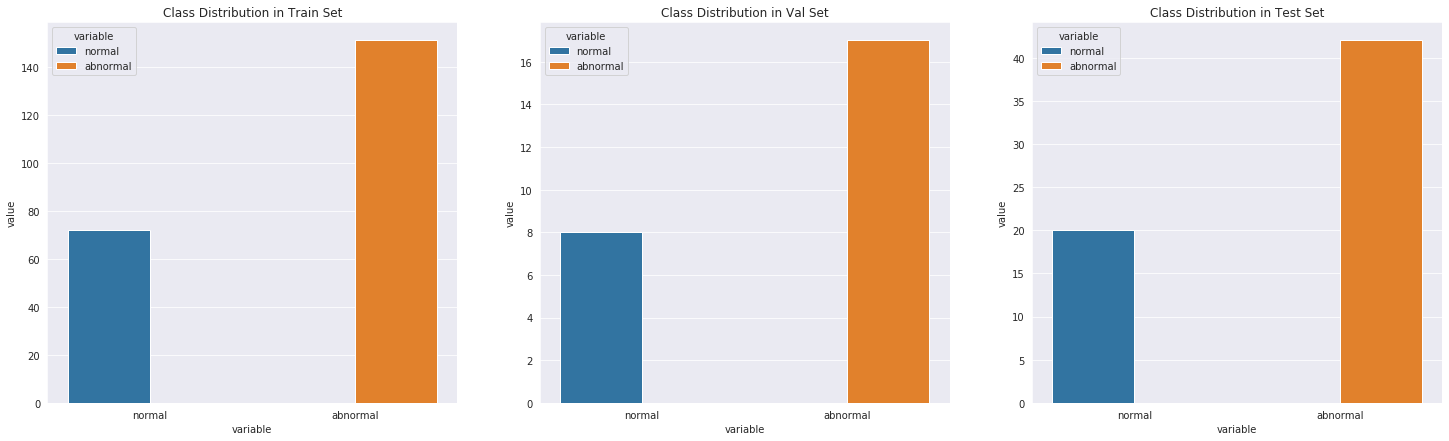

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


## Neural Net

### Define Custom Dataset

In [19]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

### Weighted Sampling

In [20]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [21]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.0139, 0.0066])

In [22]:
class_weights_all = class_weights[target_list]

In [23]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

### Model Params

In [24]:
EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.001

### Define Dataloader

In [25]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Define Neural Net Architecture

In [26]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        
        self.layer_1 = nn.Linear(12, 32) # Number of input features is 12.
        self.layer_out = nn.Linear(32, 2) 
        
        self.lrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm(x)
        x = self.lrelu(x)
        x = self.layer_out(x)
        
        return x

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
model = BinaryClassification()
model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=12, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=2, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train Model

In [29]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [30]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [31]:
print("Begin training.")

model.train()
for e in tqdm(range(1, EPOCHS+1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.87451 | Val Loss: 0.82868 | Train Acc: 32.000| Val Acc: 35.000
Epoch 002: | Train Loss: 0.71575 | Val Loss: 0.71606 | Train Acc: 33.000| Val Acc: 29.000
Epoch 003: | Train Loss: 0.70136 | Val Loss: 0.69759 | Train Acc: 37.250| Val Acc: 42.000
Epoch 004: | Train Loss: 0.69206 | Val Loss: 0.69653 | Train Acc: 52.000| Val Acc: 39.000
Epoch 005: | Train Loss: 0.67723 | Val Loss: 0.67091 | Train Acc: 70.750| Val Acc: 77.000
Epoch 006: | Train Loss: 0.65924 | Val Loss: 0.64254 | Train Acc: 73.000| Val Acc: 77.000
Epoch 007: | Train Loss: 0.66256 | Val Loss: 0.64429 | Train Acc: 66.500| Val Acc: 71.000
Epoch 008: | Train Loss: 0.64941 | Val Loss: 0.62382 | Train Acc: 68.000| Val Acc: 77.000
Epoch 009: | Train Loss: 0.63296 | Val Loss: 0.60224 | Train Acc: 70.000| Val Acc: 77.000
Epoch 010: | Train Loss: 0.62355 | Val Loss: 0.63889 | Train Acc: 71.250| Val Acc: 68.000
Epoch 011: | Train Loss: 0.61361 | Val Loss: 0.63990 | Train Acc: 72.000| Val Acc: 65.000
Epoch 012:

### Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

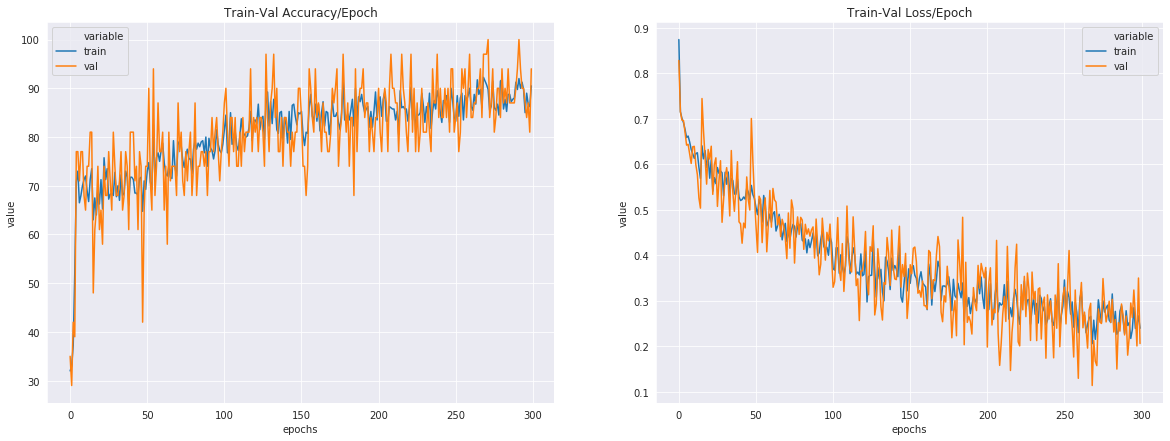

In [32]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

### Test Model

In [33]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())

In [34]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Confusion Matrix

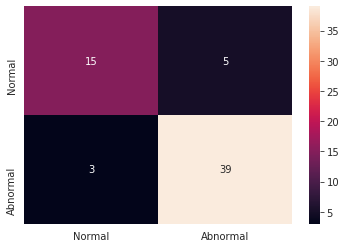

In [35]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

### Classification Report

In [36]:
print(classification_report(y_test, y_pred_list, target_names=["Normal", "Abnormal"]))

              precision    recall  f1-score   support

      Normal       0.83      0.75      0.79        20
    Abnormal       0.89      0.93      0.91        42

    accuracy                           0.87        62
   macro avg       0.86      0.84      0.85        62
weighted avg       0.87      0.87      0.87        62

